<a href="https://colab.research.google.com/github/raiutkarsh09/Time-series-practice/blob/master/Single_Layer_Neural_Network_for_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [30]:
def plot_series(time, series, format="-",start=0, end=None, label="Time Sequence" ):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time,slope=0):
    return slope*time

def seasonal_pattern(season_time):
    return np.where(season_time<0.4, np.cos(season_time *2*np.pi), 1/np.exp(3*season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time+phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd=np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
    
time = np.arange(4*365 + 1, dtype='float32')
baseline=10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)

In [18]:
split_time=1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [21]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [24]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

l0=tf.keras.layers.Dense(1, input_shape = [window_size])
model=tf.keras.models.Sequential([l0])

model.compile(loss = 'mse', optimizer= tf.keras.optimizers.SGD(lr=1e-6, momentum = 0.9))
model.fit(dataset,epochs=100, verbose=0 )

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


In [25]:
print("Layer Weights{}".format(l0.get_weights()))

Layer Weights[array([[-0.06801928],
       [-0.00410108],
       [ 0.10435009],
       [-0.03114777],
       [ 0.0334176 ],
       [-0.05844289],
       [-0.00984645],
       [ 0.02990497],
       [ 0.02061163],
       [ 0.04389539],
       [-0.03176527],
       [-0.03389129],
       [ 0.0009283 ],
       [ 0.01529591],
       [-0.04211687],
       [ 0.13772911],
       [ 0.02689948],
       [ 0.17082013],
       [ 0.2958948 ],
       [ 0.4090162 ]], dtype=float32), array([0.01930257], dtype=float32)]


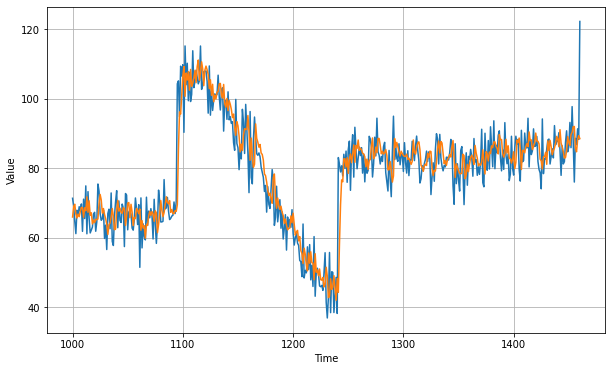

In [31]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results=np.array(forecast)[:,0,0]

plt.figure(figsize=(10,6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)